# Andre Luis Lessa Junior - Detecção de SPAM

# Setup

Nesta seção, encontram-se as configurações gerais do código, como a importação de biblioteca e a upload da base de dados de SPAM.


In [6]:
# Instalar bibliotecas
!pip install tensorflow pandas scikit-learn nltk matplotlib seaborn
!pip install kaggle
!pip install gensim

In [7]:
# Baixar base de dados
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

!kaggle datasets download -d mfaisalqureshi/spam-email
!unzip spam-email.zip

cp: cannot stat 'kaggle.json': No such file or directory
chmod: cannot access '/root/.kaggle/kaggle.json': No such file or directory
Dataset URL: https://www.kaggle.com/datasets/mfaisalqureshi/spam-email
License(s): CC0-1.0
spam-email.zip: Skipping, found more recently modified local copy (use --force to force download)
Archive:  spam-email.zip
replace spam.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: n


In [8]:
# Baixar modelo Glove
!wget http://nlp.stanford.edu/data/glove.6B.zip
!unzip glove.6B.zip

--2024-09-16 01:50:41--  http://nlp.stanford.edu/data/glove.6B.zip
Resolving nlp.stanford.edu (nlp.stanford.edu)... 171.64.67.140
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://nlp.stanford.edu/data/glove.6B.zip [following]
--2024-09-16 01:50:41--  https://nlp.stanford.edu/data/glove.6B.zip
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://downloads.cs.stanford.edu/nlp/data/glove.6B.zip [following]
--2024-09-16 01:50:41--  https://downloads.cs.stanford.edu/nlp/data/glove.6B.zip
Resolving downloads.cs.stanford.edu (downloads.cs.stanford.edu)... 171.64.64.22
Connecting to downloads.cs.stanford.edu (downloads.cs.stanford.edu)|171.64.64.22|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 862182613 (822M) [application/zip]
Saving to: ‘glove.6B.zip’

glov

In [9]:
# Importar bibliotecas
import string
import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout, SimpleRNN
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
import gensim
from gensim.models import Word2Vec

In [10]:
# Configuração NLTK
nltk.download('punkt')
nltk.download('stopwords')
stop_words = set(stopwords.words('english'))

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [11]:
# Carregar o dataset
df = pd.read_csv('spam.csv', encoding='ISO-8859-1')
df.head()

,Category,Message
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


# Análise exploratória

A base de dados originalmente possui apenas 2 colunas que é categoria, para indicar se é spam ou ham, e mensagem, mostrando o email de acordo com a classificação, não possuindo dados nulos, sendo no total 5572 dados.

In [16]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5572 entries, 0 to 5571
Data columns (total 3 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   Category     5572 non-null   object
 1   Message      5572 non-null   object
 2   text_length  5572 non-null   int64 
dtypes: int64(1), object(2)
memory usage: 130.7+ KB


Primeiro foi necessário entender a distribuição das classes, e percebe-se que o SPAM possui menor quantidade comparado com o HAM que não são considerados SPAM, isso pode afetar o modelo de forma negativa, pois há um desbalanceamento das classes o modelo pode focar apenas no HAM.

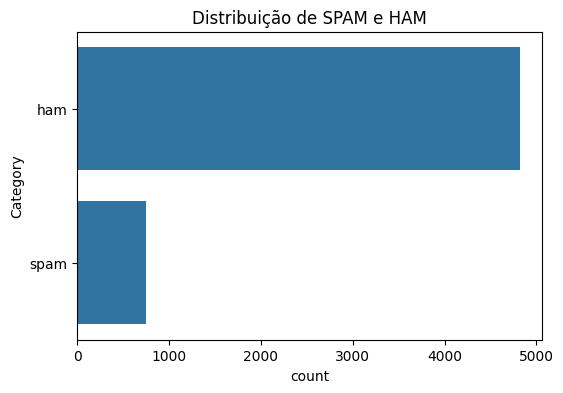

In [12]:
# Distribuição das classes
plt.figure(figsize=(6, 4))
sns.countplot(df['Category'])
plt.title('Distribuição de SPAM e HAM')
plt.show()

Percebe-se que os textos em sua maioria possui tamanhos semelhantes com apenas alguns outliers, que pode ser bom para o modelo conseguir generalizar melhor dados que são diferentes.

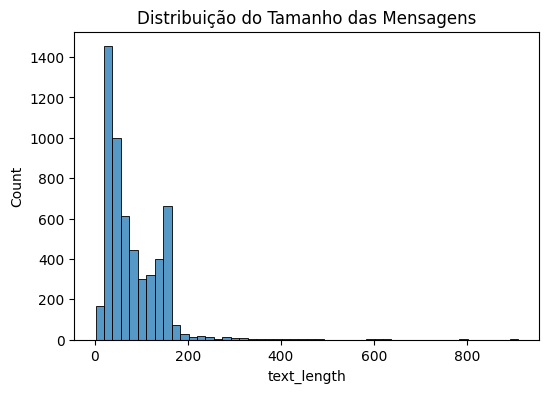

In [13]:
# Tamanho das mensagens
df['text_length'] = df['Message'].apply(len)
plt.figure(figsize=(6, 4))
sns.histplot(df['text_length'], bins=50)
plt.title('Distribuição do Tamanho das Mensagens')
plt.show()

A remoção de stopword é extremamente importante nessa base, pois a maioria das palavras que mais aparecem não são importantes para o contexto podendo dificultar o aprendizado do modelo.

<ipython-input-15-59b49b8d6d3c>:15: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=list(words), y=list(counts), palette="viridis")


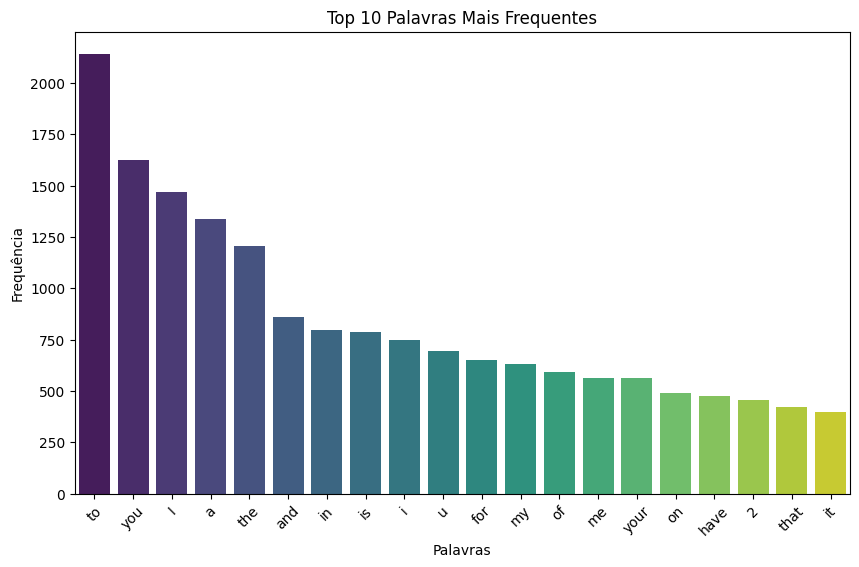

In [15]:
# Concatenar todas as palavras em uma única lista
all_words = ' '.join(df['Message']).split()

# Contar a frequência das palavras
word_freq = Counter(all_words)

# Selecionar as 10 palavras mais frequentes
top_10_words = word_freq.most_common(20)

# Separar as palavras e as frequências para plotar
words, counts = zip(*top_10_words)

# Gerar o gráfico
plt.figure(figsize=(10, 6))
sns.barplot(x=list(words), y=list(counts), palette="viridis")
plt.title('Top 10 Palavras Mais Frequentes')
plt.xlabel('Palavras')
plt.ylabel('Frequência')
plt.xticks(rotation=45)
plt.show()


# Pré Processamento de Texto

In [21]:
# Converter para minúsculas
df['cleaned_message'] = df['Message'].str.lower()

# Remover números
df['cleaned_message'] = df['cleaned_message'].apply(lambda text: re.sub(r'\d+', '', text))

# Remover pontuações
df['cleaned_message'] = df['cleaned_message'].apply(lambda text: text.translate(str.maketrans('', '', string.punctuation)))

# Tokenizar
df['cleaned_message'] = df['cleaned_message'].apply(lambda text: word_tokenize(text))

# Remover stop words
df['cleaned_message'] = df['cleaned_message'].apply(lambda tokens: [word for word in tokens if word not in stop_words])

# Transformar tokens em string
df['cleaned_message'] = df['cleaned_message'].apply(lambda tokens: ' '.join(tokens))

In [45]:
# Dataframe resultante
df.head(8)

,Category,Message,text_length,cleaned_message
0,ham,"Go until jurong point, crazy.. Available only ...",111,go jurong point crazy available bugis n great ...
1,ham,Ok lar... Joking wif u oni...,29,ok lar joking wif u oni
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,155,free entry wkly comp win fa cup final tkts st ...
3,ham,U dun say so early hor... U c already then say...,49,u dun say early hor u c already say
4,ham,"Nah I don't think he goes to usf, he lives aro...",61,nah dont think goes usf lives around though
5,spam,FreeMsg Hey there darling it's been 3 week's n...,148,freemsg hey darling weeks word back id like fu...
6,ham,Even my brother is not like to speak with me. ...,77,even brother like speak treat like aids patent
7,ham,As per your request 'Melle Melle (Oru Minnamin...,160,per request melle melle oru minnaminunginte nu...


A partir dos resultados o modelo conseguiu normalizar a base, deixando minúsculo e retirando as pontuações, entretanto ainda possui aglumas stopwords, como "n" ou "a" na prmeira linha.

# Vetorização Glove

In [23]:
# Carregar o Glove
embedding_index = {}
with open('glove.6B.100d.txt', encoding='utf-8') as f:
    for line in f:
        values = line.split()
        word = values[0]
        vector = np.asarray(values[1:], dtype='float32')
        embedding_index[word] = vector

In [24]:
# Tokenização
tokenizer = Tokenizer()
tokenizer.fit_on_texts(df['cleaned_message'])
sequences = tokenizer.texts_to_sequences(df['cleaned_message'])

word_index = tokenizer.word_index
max_len = 100
data = pad_sequences(sequences, maxlen=max_len)

In [25]:
# Criar a matriz de embedding
embedding_dim = 100
embedding_matrix = np.zeros((len(word_index) + 1, embedding_dim))
for word, i in word_index.items():
    embedding_vector = embedding_index.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector

# LSTM

In [26]:
# Separar os dados em treino e teste
X = data
y = pd.get_dummies(df['Category']).values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [27]:
# Construir o modelo LSTM
model = Sequential()
model.add(Embedding(len(word_index) + 1, embedding_dim, input_length=max_len, weights=[embedding_matrix], trainable=False))
model.add(LSTM(128, return_sequences=False))
model.add(Dropout(0.5))
model.add(Dense(2, activation='softmax'))

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding (Embedding)                │ ?                           │         857,600 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm (LSTM)                          │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ ?                           │     0 (unbuilt) │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 857,600 (3.27 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 857,600 (3.27 MB)

In [28]:
# Treinar o modelo
history = model.fit(X_train, y_train, epochs=10, batch_size=64, validation_data=(X_test, y_test))

Epoch 1/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 23s 257ms/step - accuracy: 0.8754 - loss: 0.3254 - val_accuracy: 0.9578 - val_loss: 0.1162
Epoch 2/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 26s 345ms/step - accuracy: 0.9629 - loss: 0.1098 - val_accuracy: 0.9623 - val_loss: 0.0956
Epoch 3/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 36s 283ms/step - accuracy: 0.9725 - loss: 0.0876 - val_accuracy: 0.9650 - val_loss: 0.1074
Epoch 4/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 20s 280ms/step - accuracy: 0.9769 - loss: 0.0708 - val_accuracy: 0.9668 - val_loss: 0.0914
Epoch 5/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 17s 234ms/step - accuracy: 0.9804 - loss: 0.0682 - val_accuracy: 0.9677 - val_loss: 0.0973
Epoch 6/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 19s 217ms/step - accuracy: 0.9839 - loss: 0.0481 - val_accuracy: 0.9587 - val_loss: 0.1155
Epoch 7/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 21s 223ms/step - accuracy: 0.9864 - loss: 0.0475 - val_accuracy: 0.9623 - val_loss: 0.1307
Epoch 8/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 18s 252ms/step - accuracy: 0.9850 - loss: 0.0464 - val_accu

# Avaliação Modelo Glove

In [29]:
# Avaliar o modelo
loss, accuracy = model.evaluate(X_test, y_test)
print(f'Acurácia: {accuracy}')

35/35 ━━━━━━━━━━━━━━━━━━━━ 6s 176ms/step - accuracy: 0.9733 - loss: 0.0919
Acurácia: 0.9704036116600037


35/35 ━━━━━━━━━━━━━━━━━━━━ 3s 83ms/step


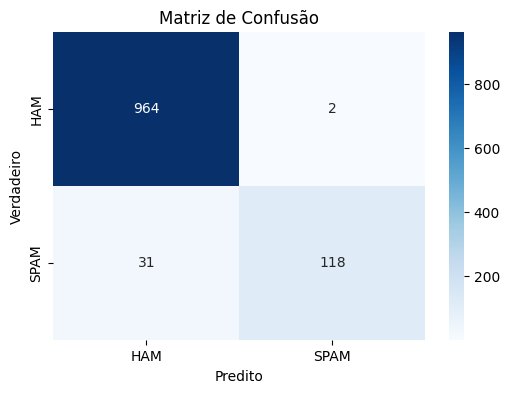

In [33]:
# Definir os rótulos das classes
class_names = ['HAM', 'SPAM']

# Predições
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = np.argmax(y_test, axis=1)

# Converter de volta para rótulos originais
y_pred_labels = [class_names[i] for i in y_pred_classes]
y_true_labels = [class_names[i] for i in y_true]

# Matriz de confusão
conf_matrix = confusion_matrix(y_true_labels, y_pred_labels)

# Plotar a matriz de confusão com os nomes das classes
plt.figure(figsize=(6, 4))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=class_names, yticklabels=class_names)
plt.title('Matriz de Confusão')
plt.xlabel('Predito')
plt.ylabel('Verdadeiro')
plt.show()


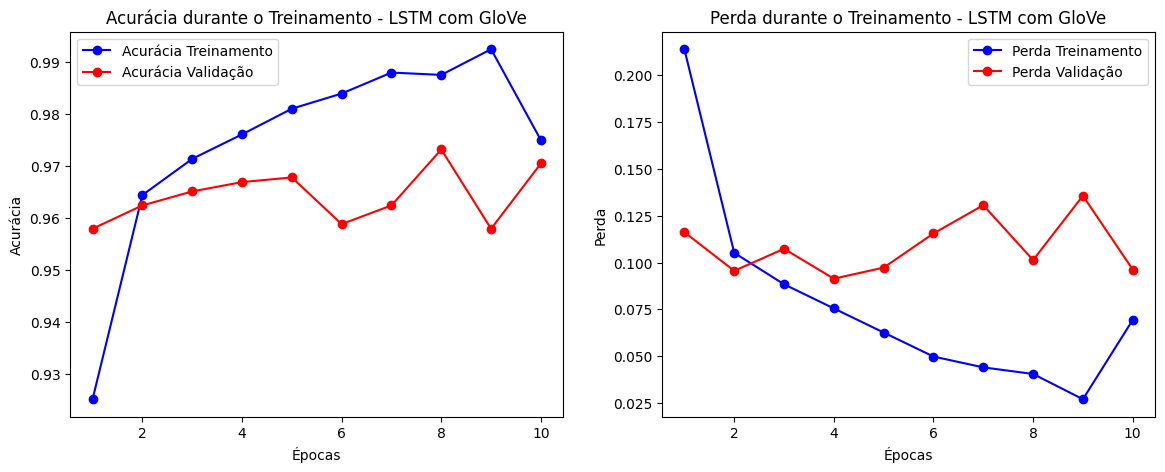

In [34]:
# Acurácia e perda do modelo LSTM
acc_lstm = history.history['accuracy']
val_acc_lstm = history.history['val_accuracy']
loss_lstm = history.history['loss']
val_loss_lstm = history.history['val_loss']
epochs_lstm = range(1, len(acc_lstm) + 1)

plt.figure(figsize=(14, 5))

# Acurácia
plt.subplot(1, 2, 1)
plt.plot(epochs_lstm, acc_lstm, 'bo-', label='Acurácia Treinamento')
plt.plot(epochs_lstm, val_acc_lstm, 'ro-', label='Acurácia Validação')
plt.title('Acurácia durante o Treinamento - LSTM com GloVe')
plt.xlabel('Épocas')
plt.ylabel('Acurácia')
plt.legend()

# Perda
plt.subplot(1, 2, 2)
plt.plot(epochs_lstm, loss_lstm, 'bo-', label='Perda Treinamento')
plt.plot(epochs_lstm, val_loss_lstm, 'ro-', label='Perda Validação')
plt.title('Perda durante o Treinamento - LSTM com GloVe')
plt.xlabel('Épocas')
plt.ylabel('Perda')
plt.legend()

plt.show()


# Modelo RNN + Word2Vec

## Vetorização Word2Vec

In [35]:
# Treinar o Word2Vec com o texto limpo
sentences = [text.split() for text in df['cleaned_message']]
word2vec_model = Word2Vec(sentences, vector_size=100, window=5, min_count=1, workers=4)

# Vetorizar as sequências usando Word2Vec
def word2vec_vectorize(sentence, model, max_len):
    vector = np.zeros((max_len, model.vector_size))
    for i, word in enumerate(sentence.split()):
        if i >= max_len:
            break
        if word in model.wv.key_to_index:
            vector[i] = model.wv[word]
    return vector

X_word2vec = np.array([word2vec_vectorize(sentence, word2vec_model, max_len) for sentence in df['cleaned_message']])


## Modelo RNN

In [36]:
# Separar os dados em treino e teste
X_train_w2v, X_test_w2v, y_train, y_test = train_test_split(X_word2vec, y, test_size=0.2, random_state=42)

In [38]:
# Construir o modelo RNN simples
rnn_model = Sequential()
rnn_model.add(SimpleRNN(128, input_shape=(max_len, 100), return_sequences=False))
rnn_model.add(Dropout(0.5))
rnn_model.add(Dense(2, activation='softmax'))

rnn_model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

rnn_model.summary()

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ simple_rnn (SimpleRNN)               │ (None, 128)                 │          29,312 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 2)                   │             258 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 29,570 (115.51 KB)

 Trainable params: 29,570 (115.51 KB)

 Non-trainable params: 0 (0.00 B)

In [39]:
# Treinar o modelo e armazenar o histórico
rnn_history = rnn_model.fit(X_train_w2v, y_train, epochs=10, batch_size=64, validation_data=(X_test_w2v, y_test))

Epoch 1/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 10s 61ms/step - accuracy: 0.8068 - loss: 0.4734 - val_accuracy: 0.8664 - val_loss: 0.3977
Epoch 2/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 4s 43ms/step - accuracy: 0.8640 - loss: 0.4177 - val_accuracy: 0.8664 - val_loss: 0.3923
Epoch 3/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 8s 79ms/step - accuracy: 0.8562 - loss: 0.4103 - val_accuracy: 0.8664 - val_loss: 0.3205
Epoch 4/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 6s 87ms/step - accuracy: 0.8486 - loss: 0.3776 - val_accuracy: 0.8664 - val_loss: 0.3621
Epoch 5/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 7s 42ms/step - accuracy: 0.8530 - loss: 0.3318 - val_accuracy: 0.8565 - val_loss: 0.2906
Epoch 6/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 6s 60ms/step - accuracy: 0.8558 - loss: 0.3223 - val_accuracy: 0.8565 - val_loss: 0.3105
Epoch 7/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 7s 82ms/step - accuracy: 0.8549 - loss: 0.3745 - val_accuracy: 0.8664 - val_loss: 0.4089
Epoch 8/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 8s 44ms/step - accuracy: 0.8669 - loss: 0.4146 - val_accuracy: 0.8664 - 

## Avaliação RNN

In [40]:
# Avaliar o modelo
rnn_loss, rnn_accuracy = rnn_model.evaluate(X_test_w2v, y_test)
print(f'Acurácia RNN: {rnn_accuracy}')

35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.8793 - loss: 0.3664
Acurácia RNN: 0.8663676977157593


35/35 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step


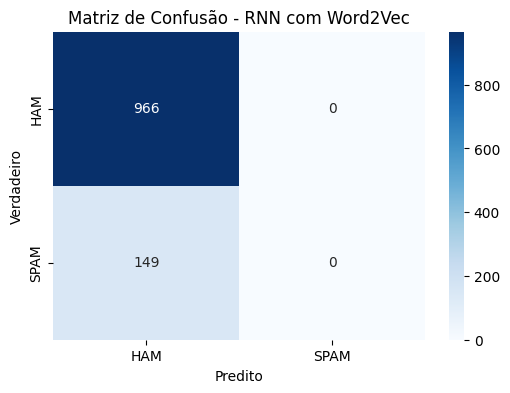

In [43]:
# Predições para o modelo RNN
y_pred_rnn = rnn_model.predict(X_test_w2v)
y_pred_rnn_classes = np.argmax(y_pred_rnn, axis=1)
y_true_rnn = np.argmax(y_test, axis=1)

# Converter de volta para rótulos originais
y_pred_labels_rnn = [class_names[i] for i in y_pred_rnn_classes]
y_true_labels_rnn = [class_names[i] for i in y_true_rnn]

# Matriz de confusão
conf_matrix_rnn = confusion_matrix(y_true_labels_rnn, y_pred_labels_rnn)

plt.figure(figsize=(6, 4))
sns.heatmap(conf_matrix_rnn, annot=True, fmt="d", cmap="Blues", xticklabels=class_names, yticklabels=class_names)
plt.title('Matriz de Confusão - RNN com Word2Vec')
plt.xlabel('Predito')
plt.ylabel('Verdadeiro')
plt.show()

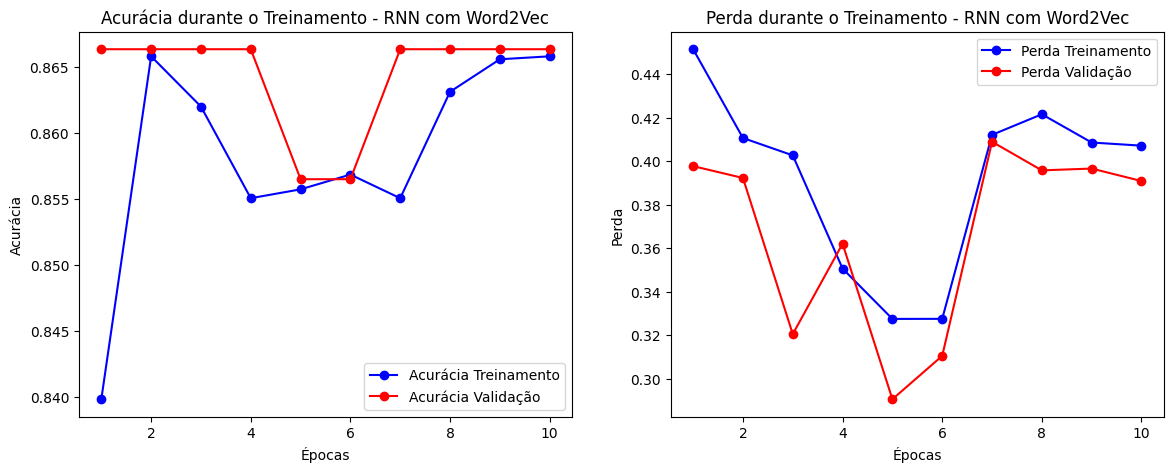

In [44]:
# Acurácia e perda do modelo RNN
acc_rnn = rnn_history.history['accuracy']
val_acc_rnn = rnn_history.history['val_accuracy']
loss_rnn = rnn_history.history['loss']
val_loss_rnn = rnn_history.history['val_loss']
epochs_rnn = range(1, len(acc_rnn) + 1)

plt.figure(figsize=(14, 5))

# Acurácia
plt.subplot(1, 2, 1)
plt.plot(epochs_rnn, acc_rnn, 'bo-', label='Acurácia Treinamento')
plt.plot(epochs_rnn, val_acc_rnn, 'ro-', label='Acurácia Validação')
plt.title('Acurácia durante o Treinamento - RNN com Word2Vec')
plt.xlabel('Épocas')
plt.ylabel('Acurácia')
plt.legend()

# Perda
plt.subplot(1, 2, 2)
plt.plot(epochs_rnn, loss_rnn, 'bo-', label='Perda Treinamento')
plt.plot(epochs_rnn, val_loss_rnn, 'ro-', label='Perda Validação')
plt.title('Perda durante o Treinamento - RNN com Word2Vec')
plt.xlabel('Épocas')
plt.ylabel('Perda')
plt.legend()

plt.show()

# Comparação

O melhor modelo foi o do LSTM com o Glove tanto em termo de resultados quanto na avaliação das matrizes de confusão. O modelo com o Glove possui uma acurácia de 97% sendo muito bom, além disso sua matriz de confusão indica que o modelo está aprendendo bem e com poucos erros, percebe-se que com o desbalanceamento das classes o Glove apresentou uma tendência em classificar como HAM, uma maneira de contornar isso é usando o Data Augmentation no SPAM para conseguir o equilibrio entre as classes. Uma coisa a ser notada nesse modelo é que durante o treinamento a perca do conjunto de validação ficou maior em comparação ao treinamento sendo necessário estudar e entender a causa.

Já no modelo RNN com o Word2Vector, percebe-se um overfitting, o modelo está sempre chutando na mesma classificação sem variar, isso mostra que o modelo não está aprendendo corretamente tendo uma acurácia de apenas 86%, a vetorização parece ter sido o maior responsável por esse resultado, pois apesar da LSTM ser melhor para captação de sequências, essas arquiteturas não deveriam apresentar uma discrepância em seus resultados conforme foi elaborado nos projetos.